Epoch 1/15
1455/1455 - 3s - loss: 0.0226 - 3s/epoch - 2ms/step
Epoch 2/15
1455/1455 - 2s - loss: 0.0095 - 2s/epoch - 1ms/step
Epoch 3/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 4/15
1455/1455 - 2s - loss: 0.0093 - 2s/epoch - 1ms/step
Epoch 5/15
1455/1455 - 2s - loss: 0.0093 - 2s/epoch - 1ms/step
Epoch 6/15
1455/1455 - 2s - loss: 0.0095 - 2s/epoch - 1ms/step
Epoch 7/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 8/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 9/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 10/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 11/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 12/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 13/15
1455/1455 - 2s - loss: 0.0092 - 2s/epoch - 1ms/step
Epoch 14/15
1455/1455 - 2s - loss: 0.0093 - 2s/epoch - 1ms/step
Epoch 15/15
1455/1455 - 2s - loss: 0.0093 - 2s/epoch - 1ms/step
12/12 [==============================] - 0s 0s/st

C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


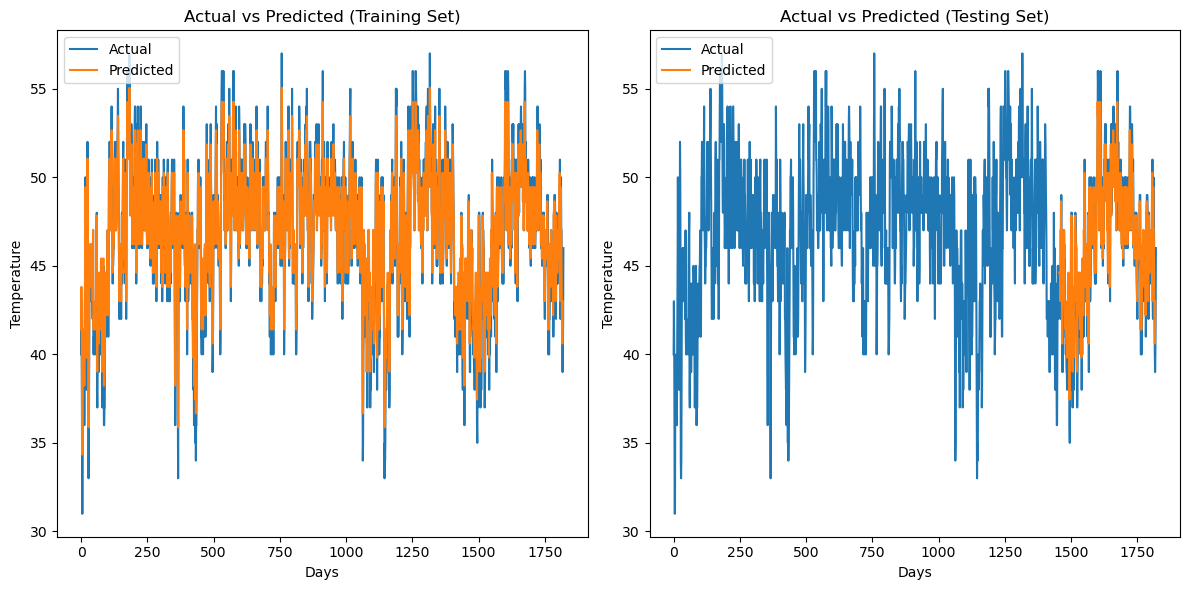

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming your dataset is in a CSV file
data = pd.read_csv('MaunaLoaDailyTemps.csv')
data = data.dropna()
# Assuming your dataset has columns: date, open, close, volume
# You may need to preprocess your data accordingly (e.g., convert date to datetime, handle missing values)

# Using 'close' as the target variable
dataset = data['AvgTemp'].values.reshape(-1, 1)

# Normalizing the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# Splitting the dataset into training and testing sets (80:20 ratio)
train_size = int(len(dataset_scaled) * 0.8)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size, :], dataset_scaled[train_size:len(dataset_scaled), :]

# Function to create sequences for LSTM
def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Creating sequences with a look-back of 1
look_back = 1
X_train, y_train = create_sequences(train, look_back)
X_test, y_test = create_sequences(test, look_back)

# Reshaping the input data to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, look_back)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the model
model.fit(X_train, y_train, epochs=15, batch_size=1, verbose=2)

# Predicting on training and testing sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transforming back to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculating RMSE
rmse_train = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
rmse_test = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

# Calculating R2 Score
r2_train = r2_score(y_train[0], train_predict[:, 0])
r2_test = r2_score(y_test[0], test_predict[:, 0])

print(f"RMSE on Training Set: {rmse_train}")
print(f"RMSE on Test Set: {rmse_test}")
print(f"R2 Score on Training Set: {r2_train}")
print(f"R2 Score on Test Set: {r2_test}")
# Plotting the actual vs predicted values for training set
# Plotting the actual vs predicted values for training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(scaler.inverse_transform(dataset_scaled), label='Actual')
plt.plot(np.concatenate([train_predict, test_predict]), label='Predicted')
plt.title('Actual vs Predicted (Training Set)')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
# Plotting the actual vs predicted values for testing set
plt.subplot(1, 2, 2)
plt.plot(scaler.inverse_transform(dataset_scaled), label='Actual')
plt.plot([None for _ in train_predict] + [x for x in test_predict], label='Predicted')
plt.title('Actual vs Predicted (Testing Set)')
plt.xlabel('Days')
plt.ylabel('Temperature')

plt.legend(loc='upper left')  # This will add the legend to your plots
plt.tight_layout()
plt.show()


In [14]:
# Calculate the mean of the 'rate' column
mean_rate = data['AvgTemp'].mean()
print(f"Mean: {mean_rate}")

# Calculate the correlation between the actual and predicted values
# Note: You need to ensure that the actual and predicted values are of the same length
correlation = np.corrcoef(y_test[0][-len(test_predict):], test_predict[:, 0])[0, 1]
print(f"Correlation between Actual and Predicted Values: {correlation}")

Mean: 46.81878088962109
Correlation between Actual and Predicted Values: 0.8352483768155716


In [15]:

data.tail()

,DATE,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
1820,12/26/2018,35.0,45.0,40.0,654,1752
1821,12/27/2018,33.0,44.0,39.0,655,1752
1822,12/28/2018,33.0,47.0,40.0,655,1753
1823,12/29/2018,36.0,47.0,42.0,655,1753
1824,12/30/2018,39.0,52.0,46.0,656,1754


In [16]:
# Get the last 'look_back' days of the scaled dataset
look_back = 2
inputs = dataset_scaled[-look_back:]

# Repeat for the number of days you want to predict
for _ in range(10):
    # Reshape the input data to match the input shape of the LSTM
    X = np.reshape(inputs, (1, 1, look_back))
    
    # Predict the next day's temperature
    pred = model.predict(X)
    
    # Append the prediction to the list of inputs
    inputs = np.append(inputs, pred)
    
    # Remove the first value of the input data
    inputs = inputs[1:]

# Transform the predictions back to the original scale
predictions = scaler.inverse_transform(inputs.reshape(-1, 1))

print("Predictions for the next 10 days:", predictions)


1/1 [==============================] - 0s 17ms/step
Predictions for the next 10 days: [[46.98891079]
 [47.00156426]]
